In [1]:
%pip install tqdm
import hemiSwap_consts as hconsts
import os
import re
from datetime import datetime
import numpy as np
import numpy.matlib as npm
import pandas as pd
import xarray as xr
import seaborn as sns
import spynal as sp
import matplotlib.pyplot as plt
from spynal.spikes import times_to_bool, rate
from itertools import product
from sklearn.cross_decomposition import CCA
import random
from scipy import stats
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from spynal.matIO import loadmat
from spynal.spikes import psth
import load_session as ls
from load_session import load_and_preprocess_session as lps
import cca_functions as ccaf
import plots as plts
import testing as tst
from sklearn.model_selection import train_test_split
import testing as tst
import json



Note: you may need to restart the kernel to use updated packages.


/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### task timing

In [4]:
time_periods = {'fixation':(-0.5,0),'sample_on':(0.1,0.6),'pre-saccade':(0.8,1.3), 'saccade': (1.3, 1.8),
                'post-saccade':(1.8,2.3)}

### choosing session id to analyze

In [5]:
hemiswap = hconsts.HemiSwap_consts('miller-lab-3', 'tiergan')
tiergan_sessions = [session_id for session_id in hemiswap.sessions['full'] if 'Tiergan' in session_id]
edith_sessions = [session_id for session_id in hemiswap.sessions['full'] if 'Edith' in session_id]

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### check: grid search for regularization parameters (WORKS!)

In [4]:
reg_params = np.logspace(-4, 2, 200)
residuals_dict, residuals_list, rate_bin_centers = lps(tiergan_sessions[1],hemiswap)
period_results = {}
residual_results = {}
for residuals, (X,Y) in zip(residuals_dict.keys(),residuals_dict.values()):
    residual_X = residuals.split('/')[0]
    residual_Y = residuals.split('/')[1]
    period_results = {}
    for time_period, (start,end) in zip(time_periods.keys(),time_periods.values()):
        target_bins = np.where((rate_bin_centers >= start) & (rate_bin_centers <= end))[0]
        target_bins = np.where((rate_bin_centers >= start) & (rate_bin_centers <= end))[0]
        X_time_win = X[:,:,target_bins] #X is a placeholder for residuals
        Y_time_win = Y[:,:,target_bins] #same for Y

        X_reshaped =np.mean(X_time_win,axis=2)
        Y_reshaped = np.mean(Y_time_win,axis=2)
        title = f'{residual_X}-{residual_Y}_{time_period}'
        X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.3, random_state=42)
        print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
        optimal_reg, first_dim_corr = ccaf.grid_search_cca(X_train,Y_train,X_test,Y_test,residual_X,residual_Y,title,reg_params)
        #TODO: i dont't think parameter reg_params is being used in the function
        period_results[time_period] = {'optimal_reg':optimal_reg,'first_dim_corr':first_dim_corr}
    residual_results[residuals] = period_results

    results_file = os.path.join('/home/dgsak/Documents/code/hemiswap_old/results/grid_regularization/results', 'all_results.npz')
    np.savez_compressed(results_file, results=residual_results) 
        

KeyboardInterrupt: 

### CCA (simple, regularized, cross validated)

In [ ]:

#TODO: add the plotting functions within a testing framework
#TODO: if the basic plots work: add the weight plots for each test run
#for the todo above look in the end of the testing.ipynb - the code is there, starts with 'update to include regCCA'
#TODO: if regularized and cross validated cca work on single session, transfer to the sessions scheme 
# and commit
#TODO: run regularized cross validated cca across sessions

#TODO: trial-concatenated option / change the windows to be non-overlapping (window=100ms,step=50ms)
#TODO: plot avg/std of all session lambdas - if they look similar: take the average lambda and use that
##TODO: fix testing framework to save train test ratio somewhere right now all experiments are running on 0.3 test size,
# as well as window size and step size for rate calculation - in the preprocessing function (load and preprocess)

### Single session testing framework

### Main goal: to create and save basic results and plots, ** once it's used for a session it can be inactivated **
##### maybe run it overnight for multiple session ids so you can have their single sessions

In [ ]:
#TODO: maybe run it overnight 
# for multiple session ids so you can have their single sessions

In [ ]:
reg_params = np.logspace(-6, 2, 100)
session_id = tiergan_sessions[1]
output_dir = f'/home/dgsak/Documents/code/hemiswap_old/results/single_sessions/'
n_folds_list = np.array([5])  # Convert to numpy array
residual_results = tst.run_testing_framework(hemiswap, session_id, n_folds_list, time_periods, reg_params, output_dir)

KeyboardInterrupt: 

In [7]:
reg_params = np.logspace(-6, 2, 100)
session_id = tiergan_sessions[1]
output_dir = f'/home/dgsak/Documents/code/hemiswap_old/results/single_sessions/'
residual_results = ls.load_results(session_id, output_dir)

## plots for single session

In [8]:
cv = 'folds_2'
subject_id = 'Tiergan'
output_dir=f'/home/dgsak/Documents/code/hemiswap_old/results/single_sessions/{subject_id}/'
results_dir = os.path.join(output_dir, f'session_hemiSwap_Tiergan_20170718')
plts.plot_components_by_r2(residual_results,cv,results_dir,time_periods,show=False)
title = f'{cv}'
plts.plot_avg_r2(residual_results, title, results_dir, cv, time_periods, show=False)
plts.plot_residual_correlations(residual_results, cv, results_dir, time_periods)

{'residual_X': 'right-right-no-swap', 'residual_Y': 'right-left-no-swap', 'weights_X': array([[-0.02348431, -0.00040439, -0.00571156, ..., -0.03493977,
         0.03184482,  0.02561224],
       [-0.0145103 , -0.00453785,  0.02795076, ..., -0.01502234,
        -0.05681562,  0.01127278],
       [-0.00675609, -0.01274904,  0.0111711 , ..., -0.02733639,
        -0.02401161,  0.05541291],
       ...,
       [-0.00162757,  0.01837198, -0.013727  , ...,  0.01348311,
        -0.02913785, -0.00485219],
       [-0.00725873,  0.01776323,  0.00098409, ...,  0.01418876,
        -0.00619178,  0.00867686],
       [ 0.00940866,  0.01407762, -0.00054604, ...,  0.0052531 ,
         0.01405605, -0.00996002]]), 'weights_Y': array([[-0.05687659, -0.00251223, -0.0126274 , ...,  0.01483481,
        -0.03286571,  0.00602624],
       [ 0.01286292, -0.00394614,  0.00235685, ..., -0.00229503,
        -0.00997332,  0.01073589],
       [-0.01718494,  0.01473208,  0.02776767, ..., -0.00836449,
         0.02709046, 

In [10]:
condition_results = ls.create_condition_results(residual_results, n_folds='folds_2')
plts.plot_condition_results(condition_results,time_periods,results_dir,cv)

0.03938111386612059 0.06683265182266589
0.006858493386079023 0.011418621919354725


# Multiple session testing framework (WORKS!)

In [11]:
len(edith_sessions)

21

In [12]:
total_sessions = len(edith_sessions)
step_size = 3
n_folds_list = [1, 2]
reg_params = np.logspace(-6, 2, 100)
time_periods = {'fixation':(-0.5,0),'sample_on':(0.1,0.6),'pre-saccade':(0.8,1.3), 'saccade': (1.3, 1.8),
                'post-saccade':(1.8,2.3)}
subject_id = 'Edith'
hemiswap = hconsts.HemiSwap_consts('miller-lab-3', 'edith')
sessions = edith_sessions
# Run the analysis

results_dir = tst.run_multi_session_framework(
    hemiswap=hemiswap,
    subject_id=subject_id,
    total_sessions=total_sessions,
    sessions = sessions,
    step_size=step_size,
    n_folds_list=n_folds_list,
    time_periods=time_periods,
    reg_params=reg_params,
    output_dir=f'/home/dgsak/Documents/code/hemiswap_old/results/across_sessions/{subject_id}/',
    batch_size=2  # Process 2 sessions at a time

)

#metadata, results = load_multi_session_results(results_dir)

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


[1, 4, 7, 10, 13, 16, 19] [1, 4]
Processing session hemiSwap_Edith_20180517
ain : numpy.array(6251,  4,1169,) of type float64

ainSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

analogChnlInfo : dict with keys[Properties,analogRange,analogUnits,channel,chnlID,chnlLabel,d2aFactor,digitalRange,electrode,file,filterCutoff,isAIN,isLFP,numSamples,session,smpRate,]

electrodeInfo : dict with keys[Properties,area,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

eventSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

fileInfo : dict with keys[Properties,analogBitRes,clockFreq,dataSource,dateTime,duration,file,numWavePreSmps,numWaveSmps,recordSys,recordSysModel,session,version,waveBitRes,waveSmpFreq,]

lfp : numpy.array(6251,230,1169,) of type float64

lfpSchema : dict with keys[dataDim,dataUnits,description

## Load multisession results

In [12]:
import json
subject_id = 'Tiergan'
output_dir=f'/home/dgsak/Documents/code/hemiswap_old/results/across_sessions/{subject_id}/'
results_dir = os.path.join(output_dir, f'multi_session_analysis_20250207_193545')
metadata, all_session_results = ls.load_multi_session_results(results_dir,subject_id = 'Tiergan')

In [ ]:
subject_id = 'Edith'
output_dir=f'/home/dgsak/Documents/code/hemiswap_old/results/across_sessions/{subject_id}/'
results_dir = os.path.join(output_dir, f'multi_session_analysis_#multi_session_analysis_20250210_133842')

## Plot sessions as traces

In [4]:
mean_corrs_folds_sessions, std_corrs_folds_sessions, time_periods, residual_pairs = ls.mean_std_across_sessions(results_dir, subject_id, cv='folds_1')

# Calculate mean and std for folds_2
mean_corrs_folds_sessions_2, std_corrs_folds_sessions_2, time_periods, residual_pairs = ls.mean_std_across_sessions(results_dir, subject_id, cv='folds_2')

# Plot for folds_1
title_1 = f'{subject_id} - mean and std of R^2 correlations across sessions - folds_1'
plts.plot_residual_pairs_traces(mean_corrs_folds_sessions, std_corrs_folds_sessions, time_periods, residual_pairs, title_1, results_dir, subject_id, cv='folds_1')

# Plot for folds_2
title_2 = f'{subject_id} - mean and std of R^2 correlations across sessions - folds_2'
plts.plot_residual_pairs_traces(mean_corrs_folds_sessions_2, std_corrs_folds_sessions_2, time_periods, residual_pairs, title_2, results_dir, subject_id,cv='folds_2')

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5398: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5399: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5402: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5404: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]


## Data Distribution check

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


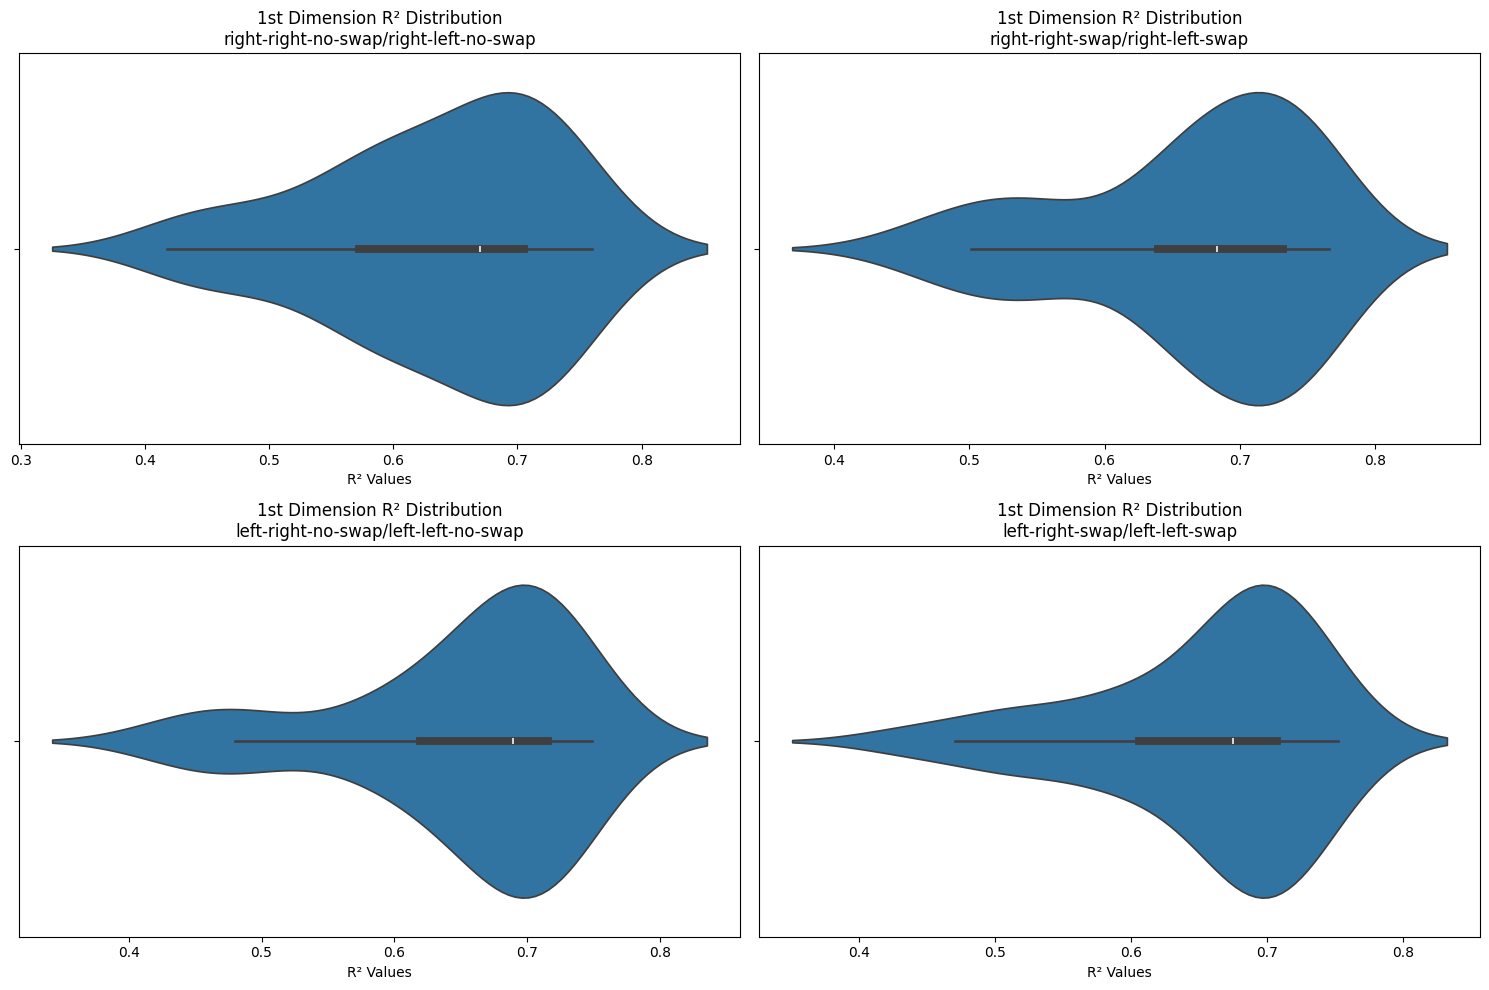

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


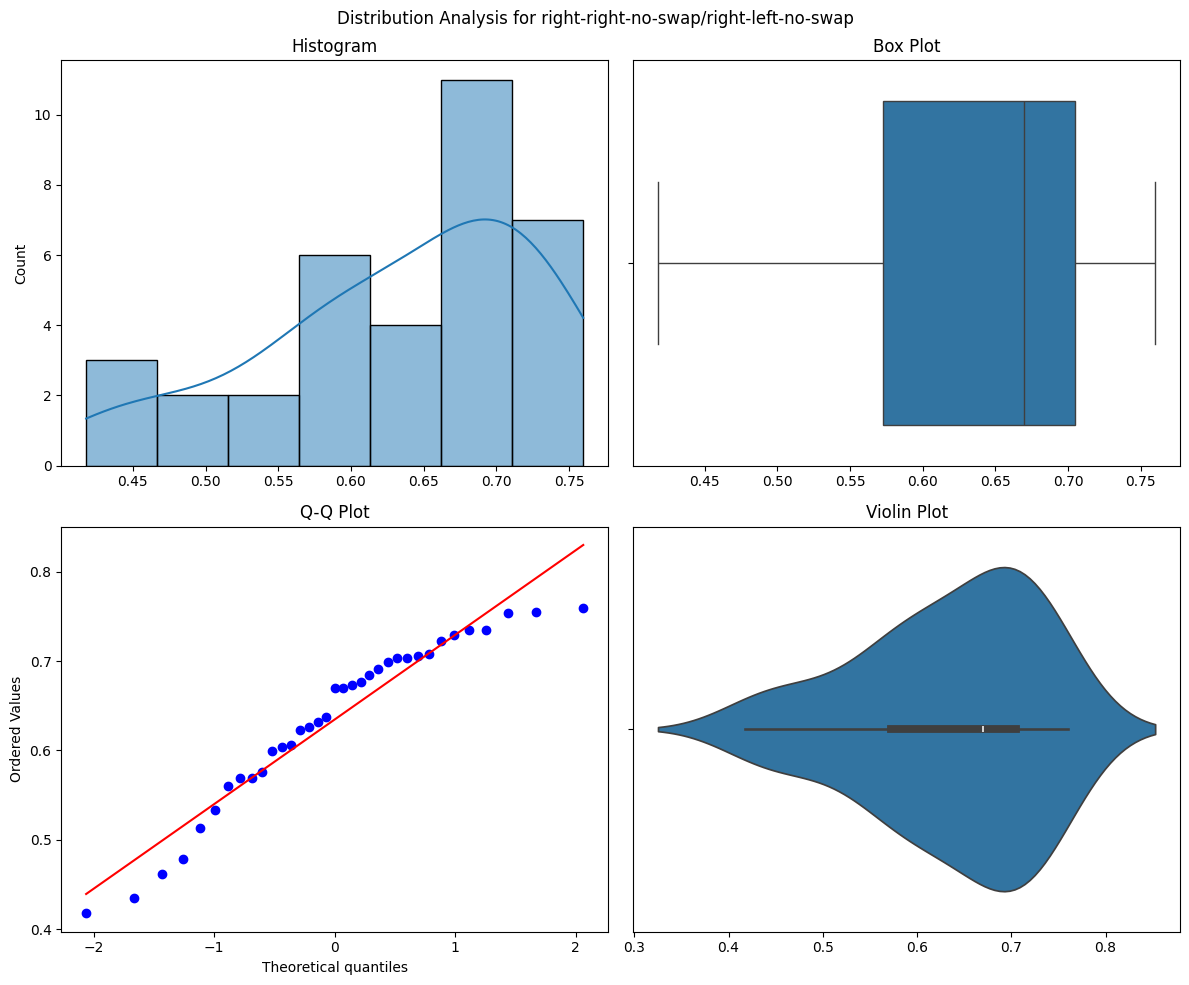

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


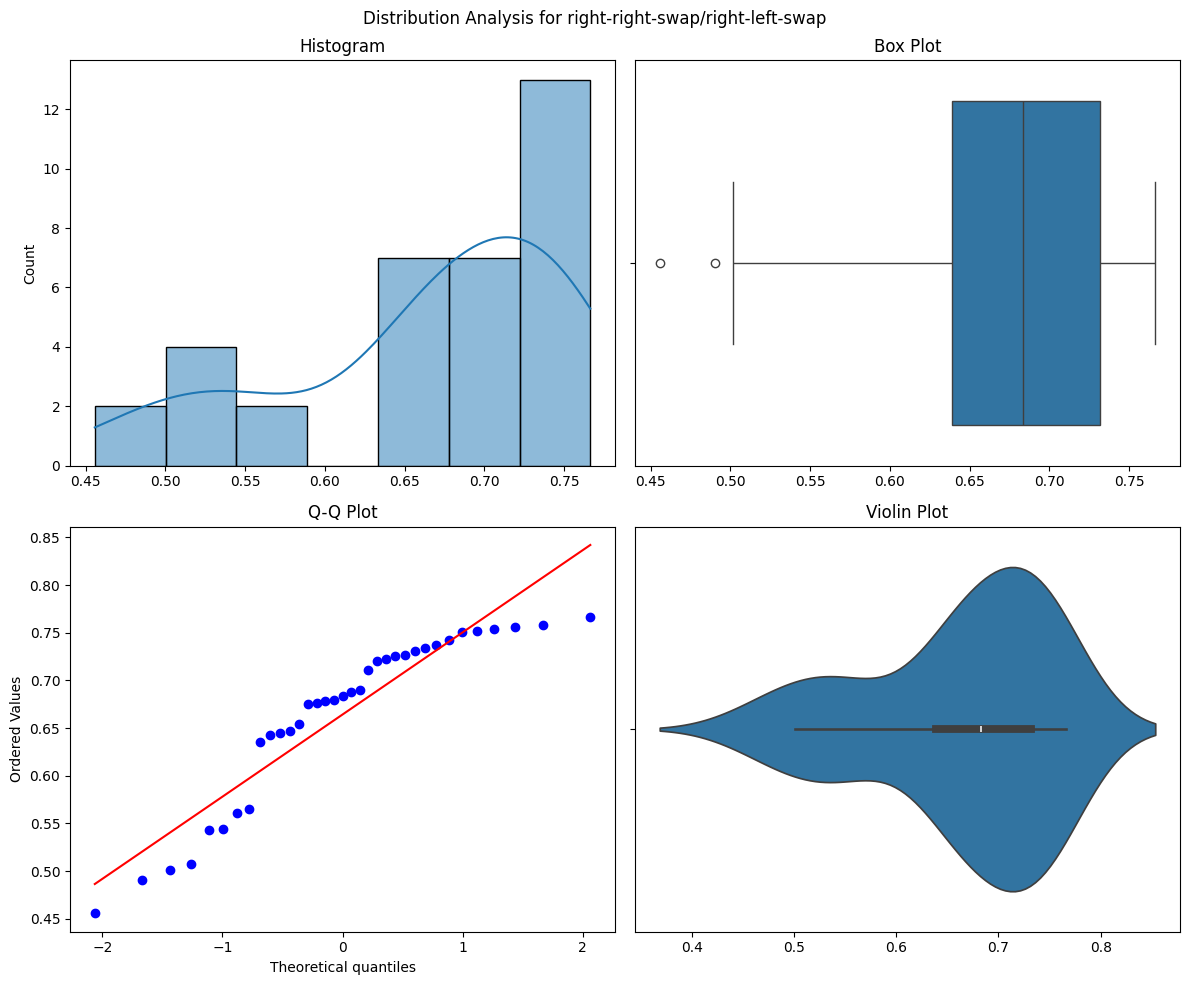

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


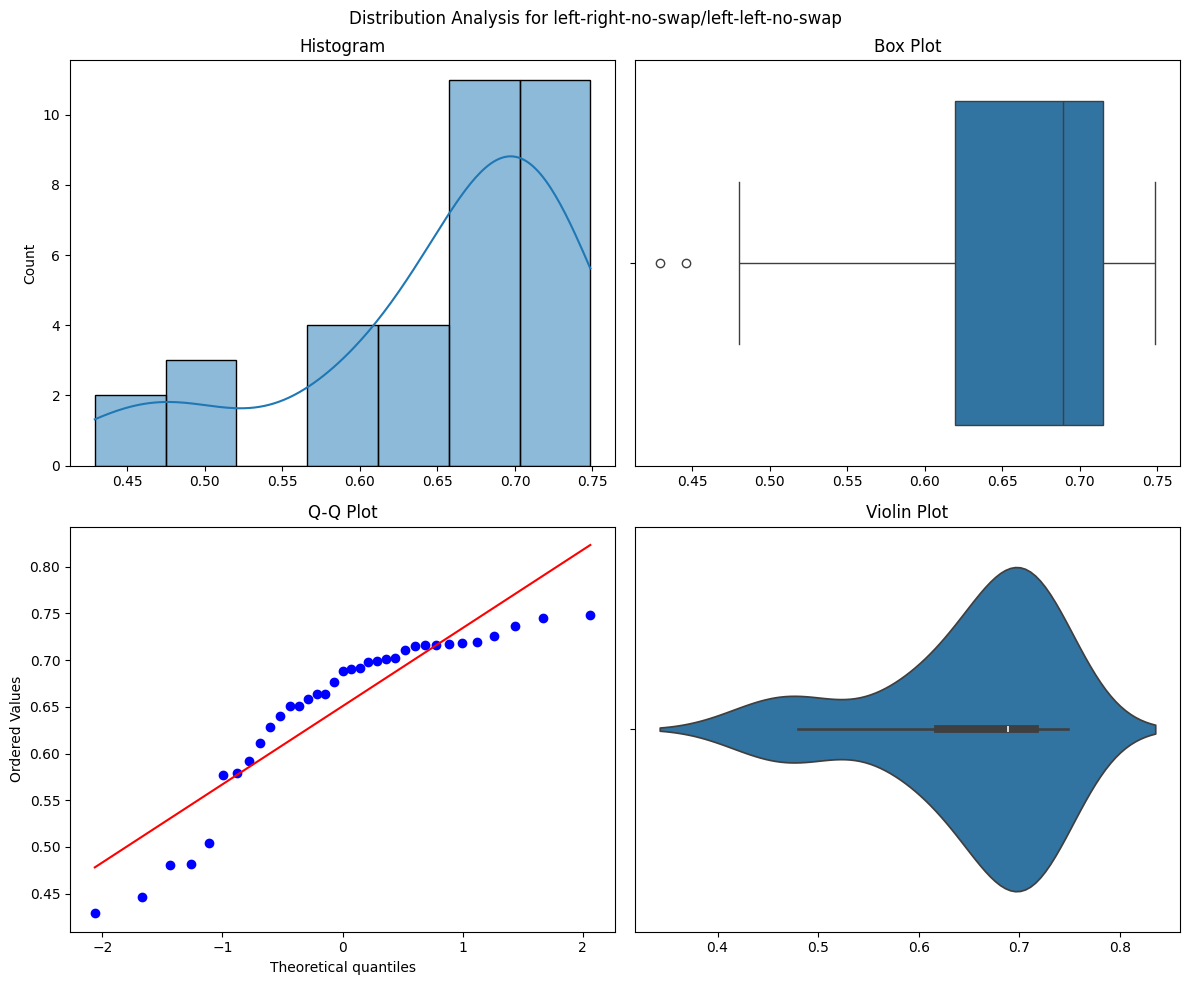

/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dgsak/miniconda3/envs/hemiswap/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


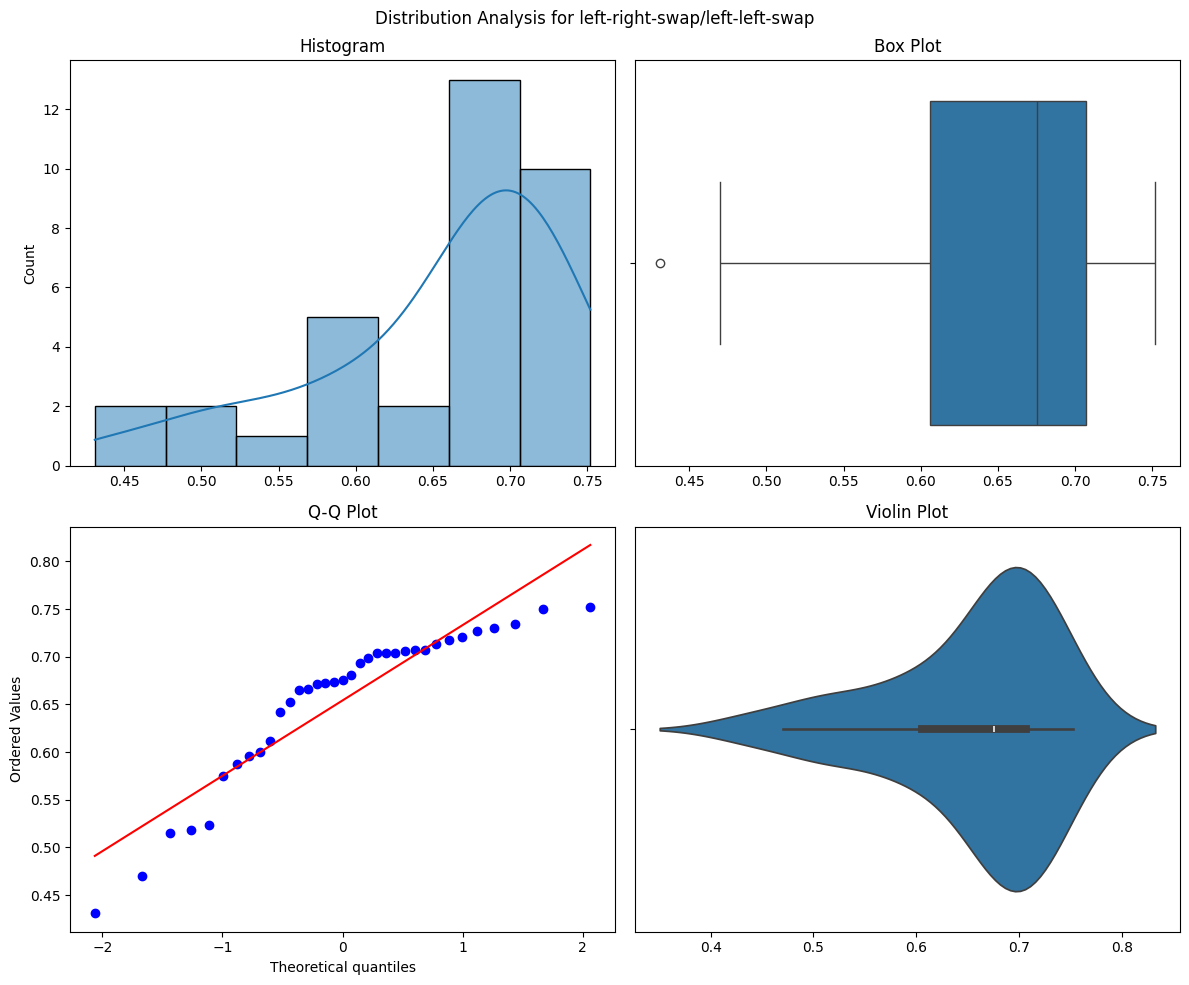

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

def visualize_distributions(results_dir, n_folds=2):
    """
    Create distribution visualizations for 1st dimension squared correlations.
    
    Parameters:
    -----------
    results_dir : str
        Path to multi-session analysis results
    n_folds : int, optional
        Number of folds to analyze (default 2)
    """
    residual_pairs = list(all_session_results[next(iter(all_session_results))].keys())
    time_periods = list(metadata['parameters']['time_periods'].keys())
    
    n_pairs = len(residual_pairs)
    n_cols = 2
    n_rows = (n_pairs + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_pairs > 1 else [axes]
    
    for pair_idx, residual_pair in enumerate(residual_pairs):
        ax = axes[pair_idx]
        all_correlations = []
        
        for session_id, session_results in all_session_results.items():
            for time_period in time_periods:
                fold_key = f'folds_{n_folds}'
                # Extract only first dimension's squared correlation
                corr = session_results[residual_pair][fold_key][time_period]['correlations'][0]
                all_correlations.append(corr * corr)  # Square the correlation
        
        sns.violinplot(x=all_correlations, ax=ax, inner='box')
        ax.set_title(f'1st Dimension R² Distribution\n{residual_pair}')
        ax.set_xlabel('R² Values')
    
    if n_pairs % 2 == 1 and n_pairs > 1:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
   
def detailed_distribution_analysis(results_dir, n_folds=2):
    """
    Create detailed distribution analysis with multiple plot types.
    """
    metadata, all_sessions_results = ls.load_multi_session_results(results_dir,subject_id='Tiergan')
    residual_pairs = list(next(iter(all_sessions_results.values())).keys())
    time_periods = list(metadata['parameters']['time_periods'].keys())

    for residual_pair in residual_pairs:
        # Collect all correlations
        all_correlations = []
        for session_results in all_sessions_results.values():
            for time_period in time_periods:
                fold_key = f'folds_{n_folds}'
                corr = session_results[residual_pair][fold_key][time_period]['correlations'][0]
                all_correlations.append(corr * corr)  # Square the correlation
        
        # Create multi-panel plot
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Histogram
        sns.histplot(all_correlations, kde=True, ax=axes[0,0])
        axes[0,0].set_title('Histogram')
        
        # Box Plot
        sns.boxplot(x=all_correlations, ax=axes[0,1])
        axes[0,1].set_title('Box Plot')
        
        # Q-Q Plot
        stats.probplot(all_correlations, plot=axes[1,0])
        axes[1,0].set_title('Q-Q Plot')
        
        # Violin Plot
        sns.violinplot(x=all_correlations, ax=axes[1,1])
        axes[1,1].set_title('Violin Plot')
        
        plt.suptitle(f'Distribution Analysis for {residual_pair}')
        plt.tight_layout()
        plt.show()

# Visualize distributions
visualize_distributions(results_dir)

# For more detailed analysis
detailed_distribution_analysis(results_dir)

### Outlier detection

In [52]:
def detect_and_remove_outliers(correlations, method='iqr'):
    """
    Remove outliers using Interquartile Range (IQR) or Z-score method.
    
    Parameters:
    -----------
    correlations : array-like
        Input correlation values
    method : str, optional
        Method for outlier detection ('iqr' or 'zscore')
    
    Returns:
    --------
    array
        Filtered correlations without outliers
    """
    import numpy as np
    from scipy import stats
    
    # Convert input to numpy array
    correlations = np.asarray(correlations)
    
    # Handle empty or single-value arrays
    if len(correlations) <= 1:
        return correlations
    
    if method == 'iqr':
        # IQR method
        Q1 = np.percentile(correlations, 25)
        Q3 = np.percentile(correlations, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (correlations >= lower_bound) & (correlations <= upper_bound)
        return correlations[mask]
    
    elif method == 'zscore':
        # Z-score method
        z_scores = np.abs(stats.zscore(correlations))
        return correlations[z_scores < 2]  # Remove points beyond 3 standard deviations
    
    return correlations

def plot_residual_pairs_traces_outliers(mean_corrs_folds_sessions, std_corrs_folds_sessions, 
                                time_periods, residual_pairs, title, results_dir, 
                                subject_id, cv, outlier_method='iqr'):
    n_pairs = len(residual_pairs)
    n_cols = 2
    n_rows = (n_pairs + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    axes = axes.flatten() if n_pairs > 1 else [axes]

    x = np.arange(len(time_periods))

    _, all_sessions_results = ls.load_multi_session_results(results_dir, subject_id)
    n_sessions = len(all_sessions_results)
    colors = plt.cm.viridis(np.linspace(0, 1, n_sessions))
    
    for pair_idx, residual_pair in enumerate(residual_pairs):
        ax = axes[pair_idx]
        
        processed_session_results = {}
        for session_id, session_results in all_sessions_results.items():
            processed_session_results[session_id] = {}
            for tp in time_periods:
                # Get first canonical correlation and compute R² first
                first_correlation = session_results[residual_pair][cv][tp]['correlations'][0]
                r2_value = first_correlation**2
                processed_session_results[session_id][tp] = r2_value
        
        # Now detect outliers on R² values for each time period
        for tp in time_periods:
            r2_values = [session_data[tp] for session_data in processed_session_results.values()]
            clean_r2 = detect_and_remove_outliers(r2_values, method=outlier_method)
            
            # Update only the sessions that weren't marked as outliers
            valid_indices = [i for i, v in enumerate(r2_values) if v in clean_r2]
            session_ids = list(processed_session_results.keys())
            
            # Create new dict with only valid sessions for this time period
            for i, session_id in enumerate(session_ids):
                if i not in valid_indices:
                    processed_session_results[session_id][tp] = np.nan
        
        # Plot individual session traces
        for session_idx, (session_id, session_r2) in enumerate(processed_session_results.items()):
            session_r2_values = [session_r2[tp] for tp in time_periods]
            # Only plot if there are valid values
            if not all(np.isnan(session_r2_values)):
                ax.plot(x, session_r2_values, '-o', color=colors[session_idx], 
                        label=f'Session {session_id}', alpha=0.7,
                        markersize=6)
        
        # Compute mean and std excluding NaN values
        mean_r2 = [np.nanmean([processed_session_results[sid][tp] for sid in processed_session_results]) 
                   for tp in time_periods]
        std_r2 = [np.nanstd([processed_session_results[sid][tp] for sid in processed_session_results]) 
                  for tp in time_periods]
        
        ax.plot(x, mean_r2, '-ko', linewidth=2, label='Mean across sessions', markersize=6)
        ax.fill_between(x, 
                       np.array(mean_r2) - np.array(std_r2), 
                       np.array(mean_r2) + np.array(std_r2), 
                       color='gray', alpha=0.2)
        
        ax.set_xlabel('Time Period')
        ax.set_ylabel('1st Canonical Variate R-squared')
        ax.set_title(f'{cv}-Residual pair {residual_pair} (Outliers: {outlier_method})')
        ax.set_xticks(x)
        ax.set_xticklabels(time_periods, rotation=45)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    if n_pairs % 2 == 1 and n_pairs > 1:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plots_dir = os.path.join(results_dir, 'plots/sessions_R2_traces')
    os.makedirs(plots_dir, exist_ok=True)
    plt.savefig(f'{plots_dir}/{title}_average_r2_session_traces_{outlier_method}.png')
    plt.close()


In [53]:
title_1 =  f'{subject_id} - mean and std of R^2 correlations across sessions - folds_1'
plot_residual_pairs_traces_outliers(mean_corrs_folds_sessions, std_corrs_folds_sessions, time_periods, residual_pairs, title_1, results_dir, subject_id, cv='folds_1', outlier_method='zscore')

title_2 =  f'{subject_id} - mean and std of R^2 correlations across sessions - folds_2'
plot_residual_pairs_traces_outliers(mean_corrs_folds_sessions_2, std_corrs_folds_sessions_2, time_periods, residual_pairs, title_2, results_dir, subject_id, cv='folds_2', outlier_method='zscore')